In [1]:
#from comet_ml import Experiment
import json
import wandb
import os
import yaml

In [2]:
import os

In [3]:
with open("/glock/notebooks/api_key.txt", "r") as f:
    api_key = json.load(f)
    print("opened")
os.environ["WANDB_API_KEY"] = api_key["api_key"]

opened


In [4]:
photos_dir = '30k'

In [5]:
from detectron2.data.datasets import register_coco_instances
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [6]:
register_coco_instances("weapons_test", {}, "/Pobrane/test_edge.json", "/Pobrane/edgetest_images")

In [7]:
register_coco_instances("weapons", {}, "/glock/"+photos_dir+"/trainval.json", "/glock/"+photos_dir)#register_coco_instances("weapons", {}, "/Pobrane/trainval.json", "/Pobrane/images")#

In [8]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [9]:
dataset_dicts = DatasetCatalog.get("weapons")
dataset_metadata = MetadataCatalog.get("weapons")
dataset_dicts_test = DatasetCatalog.get("weapons_test")
dataset_metadata_test = MetadataCatalog.get("weapons_test")

In [10]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/edgetest_images/gallery-1488212608-gettyimages-50659695.jpg


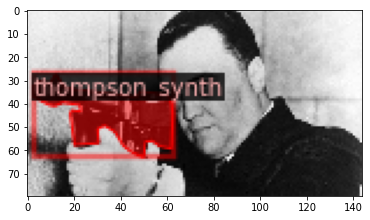

In [11]:
for d in random.sample(dataset_dicts_test, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata_test, scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

/glock/30k/RGB7b407836-f692-450e-afe1-630b02d00b29/rgb_24610.png


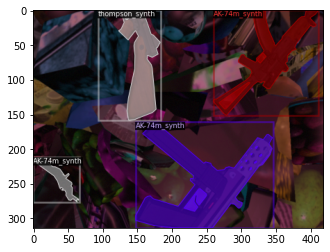

In [12]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [13]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [14]:
from datetime import datetime
import os

In [15]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 0

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.MODEL.RETINANET.NUM_CLASSES = 10

cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]

cfg.MODEL.BACKBONE.FREEZE_AT = 2
cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR =0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 40_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS =  5000
cfg.SOLVER.GAMMA = 0.8
cfg.SOLVER.STEPS = (10000, 20000, 30000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 1000
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [16]:
def cfg_node_to_dict(cfg):
    raw_cfg = yaml.safe_load(cfg.dump())
    return raw_cfg


In [17]:
#20_1.75to0.5,FREEZE_AT = 2

In [18]:
config = cfg_node_to_dict(cfg)
wandb.init(sync_tensorboard=True, project="weapons", name=photos_dir, config=config, group="objectperframe")

wandb: Currently logged in as: miotk (use `wandb login --relogin` to force relogin)


In [20]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open("/glock/config.yml", "w") as f:
    f.write(cfg.dump())

In [21]:
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [ ]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
'''
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
'''
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True)#, augmentations=build_sem_seg_train_aug(cfg)
        return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
  
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/21 14:20:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/21 14:20:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/21 14:20:26 d2.data.datasets.coco]: Loading /glock/30k/trainval.json takes 3.29 seconds.
[02/21 14:20:27 d2.data.datasets.coco]: Loaded 28644 images in COCO format from /glock/30k/trainval.json
[02/21 14:20:28 d2.data.build]: Removed 268 images with no usable annotations. 28376 images left.
[02/21 14:20:29 d2.data.build]: Distribution of instances among all 10 categories:
|   category    | #instances   |  category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-------------:|:-------------|
| AK-74m_synth  | 12890        | colt_synth  | 9723         | danwesson_s.. | 9660         |
| enfield_synth | 9549         | glock_synth | 12960        |   m4_synth    | 22557        |
|   mp5_synth   | 9690         | scar

model_final_f10217.pkl: 178MB [00:18, 9.80MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model d

[02/21 14:20:48 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/detectron2_repo/detectron2/structures/masks.py:348: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()


[02/21 14:20:56 d2.utils.events]:  eta: 4:25:04  iter: 19  total_loss: 3.516  loss_cls: 2.427  loss_box_reg: 0.2974  loss_mask: 0.6911  loss_rpn_cls: 0.05282  loss_rpn_loc: 0.0249  time: 0.4042  data_time: 0.0777  lr: 4.7962e-06  max_mem: 2340M
[02/21 14:21:05 d2.utils.events]:  eta: 4:36:20  iter: 39  total_loss: 3.382  loss_cls: 2.279  loss_box_reg: 0.3182  loss_mask: 0.6911  loss_rpn_cls: 0.05533  loss_rpn_loc: 0.03263  time: 0.4162  data_time: 0.0884  lr: 8.7922e-06  max_mem: 2340M
[02/21 14:21:13 d2.utils.events]:  eta: 4:37:22  iter: 59  total_loss: 3.086  loss_cls: 2.023  loss_box_reg: 0.3103  loss_mask: 0.6896  loss_rpn_cls: 0.04119  loss_rpn_loc: 0.02633  time: 0.4135  data_time: 0.0767  lr: 1.2788e-05  max_mem: 2340M
[02/21 14:21:21 d2.utils.events]:  eta: 4:36:04  iter: 79  total_loss: 2.722  loss_cls: 1.657  loss_box_reg: 0.3121  loss_mask: 0.6889  loss_rpn_cls: 0.04308  loss_rpn_loc: 0.02314  time: 0.4114  data_time: 0.0756  lr: 1.6784e-05  max_mem: 2340M
[02/21 14:21:29 d

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0047999.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts_test, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=dataset_metadata_test,
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())